# Dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
import warnings
from PIL import Image

#Torch
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils
from torchvision.transforms import ToTensor, v2
from torchvision.io import read_image

#Torch model
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
import time

if os.getenv("COLAB_RELEASE_TAG"):
  !pip install timm

import timm

import gdown
import zipfile
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
!nvidia-smi

Tue May 28 16:43:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1

In [ ]:
device

device(type='cuda', index=0)

# Data Processing



### Dataset loading


In [ ]:
"""
Change this before continue
"""
#Testset datalink
data_link ='https://drive.google.com/file/d/1_dsnNEIV1-0zW39Tu_FhxB8WBNsr0LQA/view?usp=sharing'
!gdown 1PjO9wFXrOaBuv28NHWjQW8cp6CsN2gYn

Downloading...
From: https://drive.google.com/uc?id=1PjO9wFXrOaBuv28NHWjQW8cp6CsN2gYn
To: /content/test_character_recognition.zip
100% 4.13M/4.13M [00:00<00:00, 71.9MB/s]


In [ ]:
"""
Change this before continue
"""
!unzip /content/test_character_recognition.zip
testset_pth = '/content/test_character_recognition'

Archive:  /content/test_character_recognition.zip
   creating: test_character_recognition/
  inflating: test_character_recognition/0.jpg  
  inflating: test_character_recognition/1.jpg  
  inflating: test_character_recognition/4.jpg  
  inflating: test_character_recognition/6.jpg  
  inflating: test_character_recognition/7.jpg  
  inflating: test_character_recognition/8.jpg  
  inflating: test_character_recognition/9.jpg  
  inflating: test_character_recognition/10.jpg  
  inflating: test_character_recognition/25.jpg  
  inflating: test_character_recognition/37.jpg  
  inflating: test_character_recognition/38.jpg  
  inflating: test_character_recognition/39.jpg  
  inflating: test_character_recognition/40.jpg  
  inflating: test_character_recognition/41.jpg  
  inflating: test_character_recognition/42.jpg  
  inflating: test_character_recognition/43.jpg  
  inflating: test_character_recognition/45.jpg  
  inflating: test_character_recognition/47.jpg  
  inflating: test_character_recogn

### Data Pre-processing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Convert image to tensor
])


In [ ]:
#Read all the image path from the folder
valid_data = [
    (os.path.join(testset_pth, image))
    for image in os.listdir(testset_pth)
]

In [ ]:
val_df = pd.DataFrame(valid_data, columns = ['image'])
val_df

,image
0,/content/test_character_recognition/1182.jpg
1,/content/test_character_recognition/2940.jpg
2,/content/test_character_recognition/2374.jpg
3,/content/test_character_recognition/2737.jpg
4,/content/test_character_recognition/1736.jpg
...,...
3295,/content/test_character_recognition/2477.jpg
3296,/content/test_character_recognition/885.jpg
3297,/content/test_character_recognition/2306.jpg
3298,/content/test_character_recognition/1684.jpg


In [ ]:
def process_img(img_path: str, width=64, height=64):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    result = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 17)
    result = cv2.resize(result, (width, height))
    result = Image.fromarray(result).convert('RGB')

    return result

In [ ]:
#Read, process image and return them as a tensor
class CNV_Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        img = process_img(img_path=img_path)
        img_tensor = self.transform(img)
        return img_tensor

In [ ]:
validset = CNV_Dataset(val_df, transform=transform)

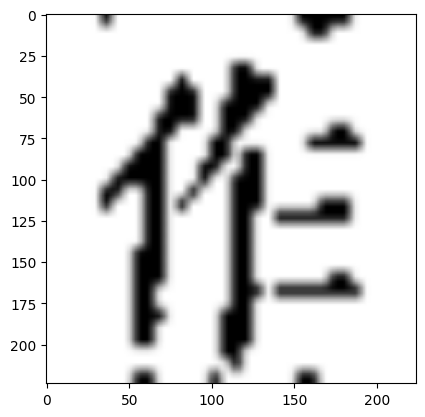

In [ ]:
#Plot a sample image
img= validset[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

### Weight Distribute

### DataLoader


In [ ]:
#Split the dataset into batch
batch_size = 64
val_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)

# Model

### Initate Model's Architecture

In [ ]:
num_classes = 2139

Resnet

In [ ]:
resnet = timm.create_model('resnet18.a1_in1k', pretrained=True, in_chans = 3, num_classes = num_classes)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
#Dowload model weight
model_link = 'https://drive.google.com/file/d/1HWfHUQCJsNXZeofEhv67jso2Ap4L6Tnd/view?usp=sharing'

if not os.path.isfile('/content/resnet18_885.pth'):
  !gdown 1HWfHUQCJsNXZeofEhv67jso2Ap4L6Tnd

Downloading...
From (original): https://drive.google.com/uc?id=1HWfHUQCJsNXZeofEhv67jso2Ap4L6Tnd
From (redirected): https://drive.google.com/uc?id=1HWfHUQCJsNXZeofEhv67jso2Ap4L6Tnd&confirm=t&uuid=8a9d6b58-53d5-4232-96a7-11bcb78a7628
To: /content/resnet18_885.pth
100% 49.2M/49.2M [00:00<00:00, 67.0MB/s]


In [ ]:
#Load model training weight
resnet_cp = f'/content/resnet18_885.pth'
loaded_checkpoint = torch.load(resnet_cp, map_location = device)
resnet.load_state_dict(loaded_checkpoint['model_state'])

<All keys matched successfully>

Effnet_b0

In [ ]:
effnet = timm.create_model('efficientnet_b0', pretrained=True, in_chans = 3, num_classes = num_classes)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
#Dowload model weight
model_link = 'https://drive.google.com/file/d/16TDhHJRo8yTxSEgn9pwcDGfoqouPUD6K/view?usp=sharing'

if not os.path.isfile('/content/EfficientnetB0_910.pth'):
  !gdown 16TDhHJRo8yTxSEgn9pwcDGfoqouPUD6K

Downloading...
From (original): https://drive.google.com/uc?id=16TDhHJRo8yTxSEgn9pwcDGfoqouPUD6K
From (redirected): https://drive.google.com/uc?id=16TDhHJRo8yTxSEgn9pwcDGfoqouPUD6K&confirm=t&uuid=6a5c35c3-30ed-4b19-8271-2ddeb80f38aa
To: /content/EfficientnetB0_910.pth
100% 81.4M/81.4M [00:01<00:00, 50.2MB/s]


In [ ]:
#Load model training weight
effnet_cp = f'/content/EfficientnetB0_910.pth'
loaded_checkpoint = torch.load(effnet_cp, map_location = device)
effnet.load_state_dict(loaded_checkpoint['model_state'])

<All keys matched successfully>

Effnet_b1

In [ ]:
effnet1 = timm.create_model('efficientnet_b1_pruned', pretrained=True, in_chans = 3, num_classes = num_classes)

model.safetensors:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

In [ ]:
#Dowload model weight
model_link = 'https://drive.google.com/file/d/10bwVWm_kNXyVLrbuH9kcAPrfdx4MVrcL/view?usp=sharing'

if not os.path.isfile('/content/Efficientnet_b1_09238_25epochs.pth'):
  !gdown 10bwVWm_kNXyVLrbuH9kcAPrfdx4MVrcL

Downloading...
From (original): https://drive.google.com/uc?id=10bwVWm_kNXyVLrbuH9kcAPrfdx4MVrcL
From (redirected): https://drive.google.com/uc?id=10bwVWm_kNXyVLrbuH9kcAPrfdx4MVrcL&confirm=t&uuid=2609b87a-12c0-40ce-8219-ec5e2ae4db6f
To: /content/Efficientnet_b1_09238_25epochs.pth
100% 94.1M/94.1M [00:00<00:00, 98.0MB/s]


In [ ]:
#Load model training weight
effnet1_cp = f'/content/Efficientnet_b1_09238_25epochs.pth'
loaded_checkpoint = torch.load(effnet1_cp, map_location = device)
effnet1.load_state_dict(loaded_checkpoint['model_state'])

<All keys matched successfully>

Xnception

In [ ]:
xception = timm.create_model('xception41.tf_in1k', pretrained=True, in_chans = 1, num_classes = num_classes);

model.safetensors:   0%|          | 0.00/108M [00:00<?, ?B/s]

In [ ]:
#Dowload model weight
model_link = 'https://drive.google.com/file/d/1G3m7DD2SyP5063UpLWaihNWk5u77_eGo/view?usp=sharing'

if not os.path.isfile('/content/xception41_886.pth'):
  !gdown 1G3m7DD2SyP5063UpLWaihNWk5u77_eGo

In [ ]:
#Load model training weight
xception_cp = f'/content/xception41_886.pth'
loaded_checkpoint = torch.load(xception_cp, map_location = device)
xception.load_state_dict(loaded_checkpoint['model_state'])

<All keys matched successfully>

### Model Ensembling


In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, resnet, effnet, effnet2, xception):
        super(EnsembleModel, self).__init__()

        # Load pretrained models
        self.resnet =  resnet
        self.effnet =  effnet
        self.effnet2 =  effnet2
        self.xception =  xception

    def forward(self, x):

        resnet_output = self.resnet(x)

        effnet_ouput = self.effnet(x)

        effnet2_ouput = self.effnet2(x)

        #Reize image input to match model requirement
        x_incept = transforms.Resize((299, 299))(x)

        #Change the chanel input to 1
        if x_incept.shape[1] != 1:
            x_incept = x_incept[:, 0:1, :, :]

        xception_ouput = self.xception(x_incept)

        # Average the predictions
        output = (resnet_output+effnet_ouput+effnet2_ouput+xception_ouput)/4

        return output

In [ ]:
model = EnsembleModel(resnet,effnet,effnet1, xception);

In [ ]:
model.to(device);

# Inference



### Parameter

In [ ]:
leaning_rate = 1e-3 #0,01
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=leaning_rate)

In [ ]:
def valid_for_test():
    model.eval()
    loss = 0
    correct = 0
    predictions = []
    with torch.no_grad():
        for idx, x in enumerate(tqdm(val_loader)):
            x = x.to(device)
            output = model(x)
            pred = output.argmax(dim=1, keepdim=True)
            image_names = [os.path.splitext(os.path.basename(path))[0] for path in val_loader.dataset.df.iloc[idx * val_loader.batch_size: (idx + 1) * val_loader.batch_size, 0]]
            for name, prediction in zip(image_names, pred):
                predictions.append([name, prediction.item()])
    predictions_df = pd.DataFrame(predictions, columns=['image_name', 'label'])
    predictions_df.to_csv(f'predictions.csv', index=False)
    return pd.read_csv(f'predictions.csv')

In [ ]:
# Final result
print(valid_for_test())

100%|██████████| 52/52 [00:47<00:00,  1.10it/s]

(0.0, 0.0,       image_name  label
0            901   1246
1           2280   2100
2           3051   1873
3           1691   1356
4           3291   1772
...          ...    ...
3295         904   1247
3296        1351   1935
3297         601   1748
3298        2836   1086
3299         816    734

[3300 rows x 2 columns])
